<a href="https://colab.research.google.com/github/Ifeeding99/tensorflow-scripts/blob/main/fake_news_predictor_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tensorflow # I installed tensorflow 2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 319, in run
    reqs, check_supported_wheels=not options.target_dir
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 128, in resolve
    requirements, max_rounds=try_to_avoid_resolution_too_deep
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 473, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.7/dist-pack

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user


In [ ]:
import tensorflow as tf
tf.__version__

'2.9.1'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
from google.colab import files
f = files.upload()

Saving train.csv to train.csv


In [ ]:
train_df = pd.read_csv('train.csv')
train_df = train_df.dropna() # dropping unusable data
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


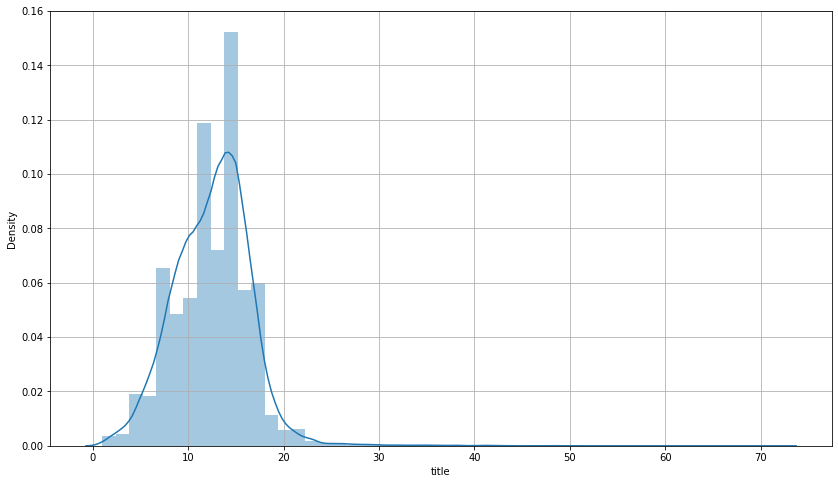

In [ ]:
aut_len = train_df['author'].apply(lambda x: len(x.split()))
text_len = train_df['text'].apply(lambda x: len(x.split()))
title_len = train_df['title'].apply(lambda x: len(x.split()))
fig = plt.figure(figsize = (14,8))
sns.distplot(title_len)
plt.grid()

In [ ]:
authors = train_df.author
texts = train_df.text
titles = train_df.title
labels = np.array(train_df.label)
labels = np.expand_dims(labels, axis = 1)
labels[0]

array([1])

In [ ]:
from transformers import AutoTokenizer, TFAutoModel # I used the BERT transformer, I needed the model with its pretrained weights and its tokenizer
checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
max_length_text = 5000
max_length_title = 30
max_length_author = 10
encoded = tokenizer('Hello world!', max_length = max_length_author, truncation = True, padding = True, return_tensors = 'tf', return_token_type_ids=False) # example of tokenization of a word
ids, att = encoded['input_ids'], encoded['attention_mask']
var = bert(ids, att)[0] # [0] is last layer output, [1] is last layer output after pooling
var

<tf.Tensor: shape=(1, 5, 768), dtype=float32, numpy=
array([[[ 0.37628248,  0.36770424,  0.49426252, ..., -0.16608262,
          0.59425074, -0.15928614],
        [ 0.71212834, -0.3678832 ,  0.8582983 , ..., -0.23903587,
          0.5695609 , -0.08859257],
        [ 0.65599316,  0.47040492,  0.48593396, ..., -0.5635841 ,
         -0.26219305, -0.47541213],
        [ 0.6383523 ,  0.08109612,  0.81820375, ...,  0.26848638,
          0.3920054 ,  0.15532847],
        [ 0.7409243 ,  0.5909869 ,  0.32814404, ..., -0.32533774,
          0.97608364, -0.7480263 ]]], dtype=float32)>

In [ ]:
# creating empty array to store tokenized data
tokenized_texts_ids = np.zeros((18285, max_length_text))
tokenized_texts_attention = np.zeros((18285, max_length_text))
tokenized_titles_ids = np.zeros((18285, max_length_title))
tokenized_titles_attention = np.zeros((18285, max_length_title))
tokenized_authors_ids = np.zeros((18285, max_length_author))
tokenized_authors_attention = np.zeros((18285, max_length_author))

# putting tokenized data in the arrays
for i,el in enumerate(train_df.title):
  t_title = tokenizer(el, max_length = max_length_title, padding = 'max_length', truncation = True, return_tensors = 'tf', return_token_type_ids=False)
  tokenized_titles_ids[i,:] = t_title['input_ids']
  tokenized_titles_attention[i,:] = t_title['attention_mask']

for i,el in enumerate(train_df.author):
  t_author = tokenizer(el, max_length = max_length_author, padding = 'max_length', truncation = True, return_tensors = 'tf', return_token_type_ids=False)
  tokenized_authors_ids[i,:] = t_author['input_ids']
  tokenized_authors_attention[i,:] = t_author['attention_mask']

for i,el in enumerate(train_df.text):
  t_text = tokenizer(el, max_length = max_length_text, padding = 'max_length', truncation = True, return_tensors = 'tf', return_token_type_ids=False)
  tokenized_texts_ids[i,:] = t_text['input_ids']
  tokenized_texts_attention[i,:] = t_text['attention_mask']

In [ ]:
# I need to expand the dimensions of the arrays because tensorflow and BERT want data structured like this
tokenized_texts_ids = tf.expand_dims(tokenized_texts_ids, axis = 1)
tokenized_texts_attention = tf.expand_dims(tokenized_texts_attention, axis = 1)

tokenized_titles_ids = tf.expand_dims(tokenized_titles_ids, axis = 1)
tokenized_titles_attention = tf.expand_dims(tokenized_titles_attention, axis = 1)

tokenized_authors_ids = tf.expand_dims(tokenized_authors_ids, axis = 1)
tokenized_authors_attention = tf.expand_dims(tokenized_authors_attention, axis = 1)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tokenized_titles_ids, tokenized_titles_attention,tokenized_authors_ids, tokenized_authors_attention,tokenized_texts_ids, tokenized_texts_attention, labels))

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dropout, Flatten, GlobalMaxPool1D, BatchNormalization, Concatenate, Dense

In [ ]:
def name_subsets (tokenized_titles_ids, tokenized_titles_attention,tokenized_authors_ids, tokenized_authors_attention,tokenized_texts_ids, tokenized_texts_attention, labels):
  return {'tokenized_titles_ids':tokenized_titles_ids, 'tokenized_titles_attention':tokenized_titles_attention, 'tokenized_authors_ids':tokenized_authors_ids, 'tokenized_authors_attention':tokenized_authors_attention, 'tokenized_texts_ids':tokenized_texts_ids, 'tokenized_texts_attention':tokenized_texts_attention},labels
train_dataset = train_dataset.map(name_subsets)

In [ ]:
train_dataset = train_dataset.shuffle(1000000).batch(32)

In [ ]:
# model
title_ids_input = Input(shape = (max_length_title), name = 'tokenized_titles_ids', dtype = 'int32')
title_attention_input = Input(shape = (max_length_title), name = 'tokenized_titles_attention', dtype = 'int32')

author_ids_input = Input(shape = (max_length_author), name = 'tokenized_authors_ids', dtype = 'int32')
author_attention_input = Input(shape = (max_length_author), name = 'tokenized_authors_attention', dtype = 'int32')

text_ids_input = Input(shape = (max_length_text), name = 'tokenized_texts_ids', dtype = 'int32')
text_attention_input = Input(shape = (max_length_text), name = 'tokenized_texts_attention', dtype = 'int32')

bert_title = bert(input_ids = title_ids_input, attention_mask = title_attention_input, token_type_ids = None)[0]
bert_author = bert(input_ids = author_ids_input, attention_mask = author_attention_input, token_type_ids = None)[0]
bert_text = bert(input_ids = text_ids_input, attention_mask = text_attention_input, token_type_ids = None)[0]

pooling_title = GlobalMaxPool1D()(bert_title)
normalization_title = BatchNormalization()(pooling_title)
pre_dense_title = Dense(units = 256, activation = 'relu')(normalization_title)

pooling_author = GlobalMaxPool1D()(bert_author)
normalization_author = BatchNormalization()(pooling_author)
pre_dense_author = Dense(units = 256, activation = 'relu')(normalization_author)

pooling_text = GlobalMaxPool1D()(bert_text)
normalization_text = BatchNormalization()(pooling_text)
pre_dense_text = Dense(units = 256, activation = 'relu')(normalization_text)

concat = Concatenate()([pre_dense_title, pre_dense_author, pre_dense_text])

h1 = Dense(units = 256, activation = 'relu')(concat)
d1 = Dropout(0.5)(h1)
h2 = Dense(units = 256, activation = 'relu')(d1)
d2 = Dropout(0.5)(h2)
h3 = Dense(units = 64, activation = 'relu')(d2)
d3 = Dropout(0.5)(h3)
output_layer = Dense(units = 1, activation = 'sigmoid')(d3)

model = Model (inputs = [title_ids_input, title_attention_input, author_ids_input, author_attention_input, text_ids_input, text_attention_input], outputs =output_layer)

# setting to untrainable the BERT layers
model.layers[6].trainable = False
model.layers[7].trainable = False
model.layers[8].trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tokenized_titles_ids (InputLay  [(None, 30)]        0           []                               
 er)                                                                                              
                                                                                                  
 tokenized_titles_attention (In  [(None, 30)]        0           []                               
 putLayer)                                                                                        
                                                                                                  
 tokenized_authors_ids (InputLa  [(None, 10)]        0           []                               
 yer)                                                                                         

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

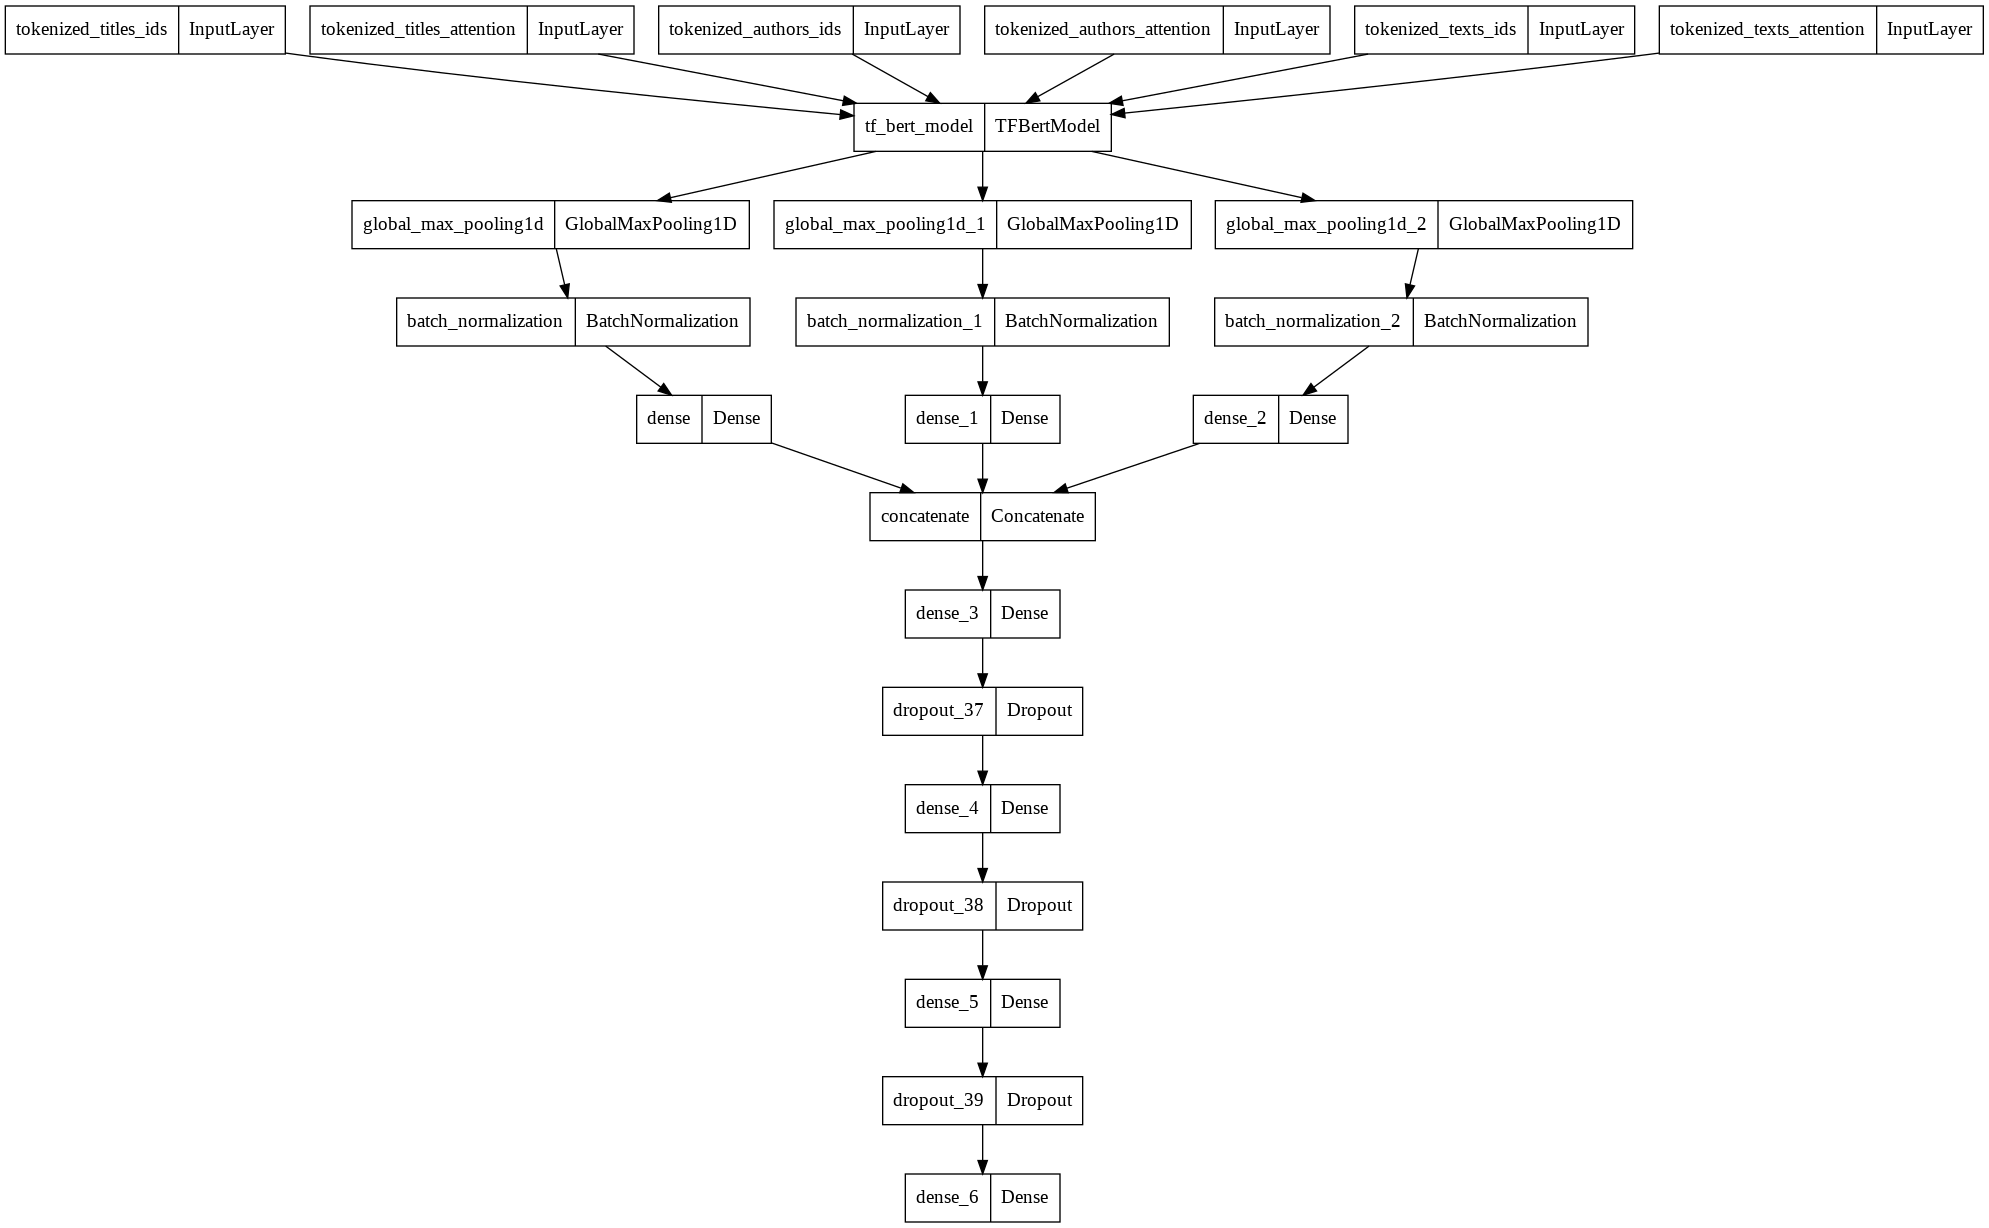

In [ ]:
tf.keras.utils.plot_model(model, to_file = 'model.png')

In [ ]:
model.fit(train_dataset,
          epochs = 10)

Epoch 1/10
